In [8]:
%reload_ext autoreload
%autoreload 2
import os
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

# Document preprocessor

In [5]:
from src.document_preprocessor import RegexTokenizer

preprocessor = RegexTokenizer("\w+(?:-\w+)*(?:'[^stmrvld]\w*)*", lowercase=True)

# Index

In [3]:
from src.indexing import BasicInvertedIndex

index = BasicInvertedIndex()
index.load("output/index_v1")

# Stopwords

In [6]:
from src.utils import load_txt

stopwords = set(load_txt('../data/stopwords_updated.txt'))
len(stopwords)

550

# Relevance dataset

In [9]:
rel_df = pd.read_csv("../data/relevance_test.csv")

In [11]:
len(rel_df), rel_df["query"].nunique()

(654, 13)

In [12]:
rel_df["rel"].value_counts()

rel
1    415
2     99
4     63
5     41
3     36
Name: count, dtype: int64

# Random

In [13]:
from src.ranker import Random, Ranker

random_scorer = Random(index)
random_ranker = Ranker(index, preprocessor, stopwords, random_scorer)

In [14]:
from src.relevance import run_relevance_tests

metrics_random = run_relevance_tests("../data/relevance_test.csv", ranker=random_ranker, encoding="utf-8-sig")

In [15]:
metrics_random['map'], metrics_random['ndcg']

(0.0, 0.0025518123461001855)

In [23]:
with open('output/metrics_random.json', 'w') as f:
    json.dump(metrics_random, f)

# TF-IDF Ranker

In [18]:
from src.ranker import TF_IDF, Ranker

tfidf_scorer = TF_IDF(index)
tfidf_ranker = Ranker(index, preprocessor, stopwords, tfidf_scorer)

In [19]:
from src.relevance import run_relevance_tests

metrics_tfidf = run_relevance_tests("../data/relevance_test.csv", ranker=tfidf_ranker, encoding="utf-8-sig")

In [20]:
metrics_tfidf['map'], metrics_tfidf['ndcg']

(0.24098901098901096, 0.5555199402545172)

In [22]:
with open('output/metrics_tfidf.json', 'w') as f:
    json.dump(metrics_tfidf, f)

# BM25 Ranker

In [24]:
from src.ranker import BM25, Ranker

bm25_scorer = BM25(index)
bm25_ranker = Ranker(index, preprocessor, stopwords, bm25_scorer)

In [25]:
from src.relevance import run_relevance_tests

metrics_bm25 = run_relevance_tests("../data/relevance_test.csv", ranker=bm25_ranker, encoding="utf-8-sig")

In [26]:
metrics_bm25['map'], metrics_bm25['ndcg']

(0.3393813593813594, 0.5792890913146169)

In [27]:
with open('output/metrics_bm25.json', 'w') as f:
    json.dump(metrics_bm25, f)

# Compare metrics

In [28]:
ranker_metrics = {
    "Random": metrics_random,
    "TF-IDF": metrics_tfidf,
    "BM25": metrics_bm25,
}

metrics_df = []
for ranker, metrics in ranker_metrics.items():
    metrics_df.append({
        "ranker": ranker, "metric": "MAP@10", 
        "mean_score": metrics["map"], "scores": metrics["map_list"]
    })
    metrics_df.append({
        "ranker": ranker, "metric": "NDCG@10", 
        "mean_score": metrics["ndcg"], "scores": metrics["ndcg_list"]
    })

metrics_df = pd.DataFrame(metrics_df)

In [29]:
metrics_df_long = metrics_df.drop("mean_score", axis=1).explode("scores")
metrics_df_long.head()

,ranker,metric,scores
0,Random,MAP@10,0
0,Random,MAP@10,0
0,Random,MAP@10,0
0,Random,MAP@10,0
0,Random,MAP@10,0


In [31]:
metrics_df_long.to_csv("output/metrics_baselines.csv", index=False)

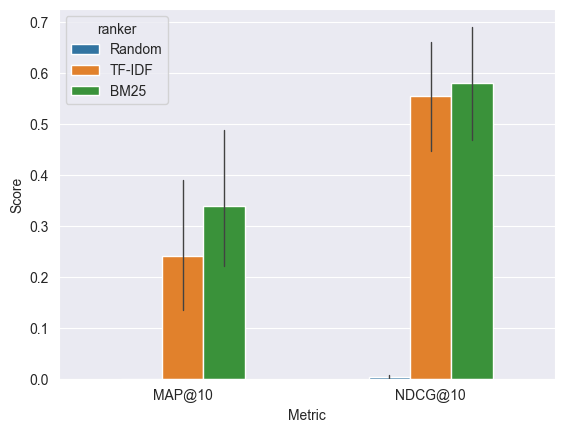

In [34]:
sns.barplot(data=metrics_df_long, x="metric", y="scores", hue="ranker", 
            estimator='mean', errorbar=('ci', 95), width=0.5, errwidth=1)

# plt.title("Mean Performance of Rankers on Test Set (with 95% C.I.)")
# plt.legend(bbox_to_anchor=(1,1))
plt.xlabel("Metric")
plt.ylabel("Score")
plt.show()